In [27]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

LAG = 2

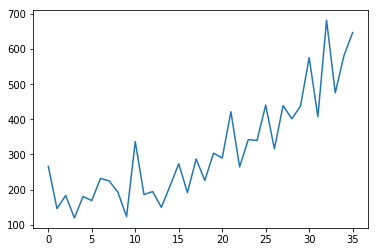

In [15]:
# data 1
data = Series([266, 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8, 122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287, 226, 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9, 439.3, 401.3, 437.4, 575.5, 407.6, 682, 475.3, 581.3, 646.9])
plt.plot(data)

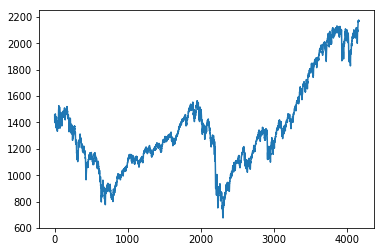

In [3]:
# data 2
with open('./stock_price.dat', 'r') as f:
    data = Series([float(price) for price in f.read().split()])
    plt.plot(data)

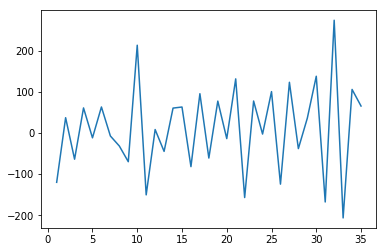

In [16]:
diff = data.diff(1)
diff.dropna(inplace=True)
plt.plot(diff)

In [28]:
shifted = [diff.shift(i) for i in range(0, LAG + 1)]
shifted.reverse()

dataset = DataFrame(pd.concat(shifted, axis=1))
dataset.dropna(inplace=True)
dataset.head()

,0,1,2
3,-120.1,37.2,-63.8
4,37.2,-63.8,61.0
5,-63.8,61.0,-11.8
6,61.0,-11.8,63.3
7,-11.8,63.3,-7.3


In [29]:
train_cv, test = train_test_split(dataset, test_size=0.25)
train, cv = train_test_split(train_cv, test_size=0.33)
train.shape, cv.shape, test.shape

((16, 3), (8, 3), (9, 3))

In [30]:
scaler = MinMaxScaler((-1, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
cv_scaled = scaler.transform(cv)
test_scaled = scaler.transform(test)
# dataset = scaler.inverse_transform(dataset_scaled)

In [31]:
BATCH_SIEE = 4
train_len = len(train_scaled) // BATCH_SIEE * BATCH_SIEE
train_scaled = train_scaled[:train_len]
train_scaled.shape

(16, 3)

In [32]:
X, y = train_scaled[:,:-1], train_scaled[:,-1]
X = X.reshape((X.shape[0], 1, X.shape[1]))
X.shape, y.shape

((16, 1, 2), (16,))

In [33]:
def get_model():
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(BATCH_SIEE, X.shape[1], X.shape[2]), stateful=True))

#     model.add(LSTM(16, batch_input_shape=(BATCH_SIEE, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
#     model.add(LSTM(16, batch_input_shape=(BATCH_SIEE, X.shape[1], X.shape[2]), stateful=True, return_sequences=False))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
#     model.add(Dense(1))
    model.compile(loss='mse', optimizer='adadelta')
#     model.compile(loss='mse', optimizer='rmsprop')
    return model

In [34]:
def make_prediction(model, X):
    gap = BATCH_SIEE - X.shape[0] % BATCH_SIEE
    if gap != 0:
        X = np.concatenate([X, X[:gap]], axis=0)
        
    X_reshape = X.reshape((X.shape[0], 1, X.shape[1]))
    
    y_pred = model.predict(X_reshape, batch_size=BATCH_SIEE)
    
    data_scaled = np.concatenate([X, y_pred], axis=1)
    data = scaler.inverse_transform(data_scaled)
    y_pred = data[:, -1]
    
    if gap != 0:
        y_pred = y_pred[:-gap]

    return y_pred
        
def evaluate(model, dataset_scaled, title=''):
    X = dataset_scaled[:,:-1]
    dataset = scaler.inverse_transform(dataset_scaled)
    y_true = dataset[:, -1]
    y_pred = make_prediction(model, X)
    
    grow_true, grow_pred = [0], [0]
    value_true, value_pred = 0, 0
    for i in range(y_true.shape[0]):
        value_true += y_true[i]
        value_pred += y_pred[i]
        
        grow_true.append(value_true)
        grow_pred.append(value_pred)    
    
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return y_true, y_pred, rmse, grow_true, grow_pred

In [43]:
best_cv_loss = 999999
EPOCHS = 1000000

MAX_PATIENCE = 3
patience = 0

train_loss_his, cv_loss_his = [], []
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (4, 4)                    112       
_________________________________________________________________
dropout_6 (Dropout)          (4, 4)                    0         
_________________________________________________________________
dense_6 (Dense)              (4, 1)                    5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


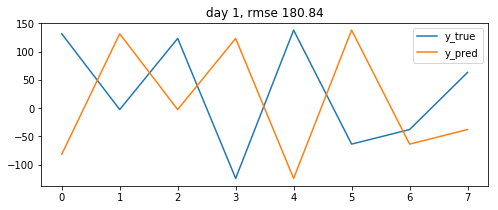

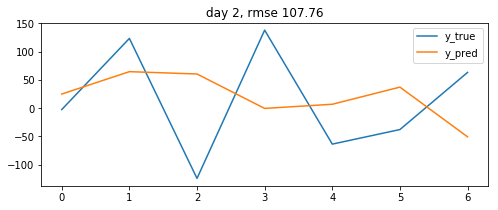

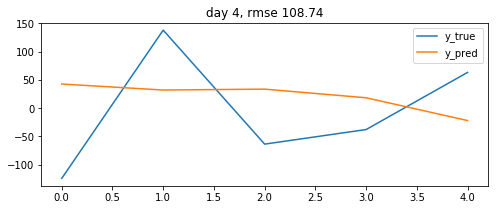

108.73853502783639

In [36]:
def avg_evaluate(dataset_scaled, last_days = 1):
    X = dataset_scaled[:,:-1]
    dataset = scaler.inverse_transform(dataset_scaled)
    y_true = dataset[:, -1]
    
    y_pred = np.zeros_like(y_true)
    for i in range(last_days, y_pred.shape[0]):
        y_pred[i] = np.mean(y_true[i-last_days: i])
    
    y_true, y_pred = y_true[last_days:], y_pred[last_days:]
    rmse = sqrt(mean_squared_error(y_true, y_pred))

    fig, ax = plt.subplots(1, 1, figsize = (8, 3))

    ax.plot(y_true, label='y_true')
    ax.plot(y_pred, label='y_pred')
    ax.set_title('day {}, rmse {:.2f}'.format(last_days, rmse))
    ax.legend()

    plt.show()
        
    return rmse

avg_evaluate(test_scaled, last_days=1)
avg_evaluate(test_scaled, last_days=2)
avg_evaluate(test_scaled, last_days=4)
# avg_evaluate(test_scaled, last_days=8)
# avg_evaluate(test_scaled, last_days=12)
# avg_evaluate(test_scaled, last_days=16)
# avg_evaluate(test_scaled, last_days=32)
# avg_evaluate(test_scaled, last_days=64)
# avg_evaluate(test_scaled, last_days=128)
# avg_evaluate(test_scaled, last_days=258)
# avg_evaluate(test_scaled, last_days=512)

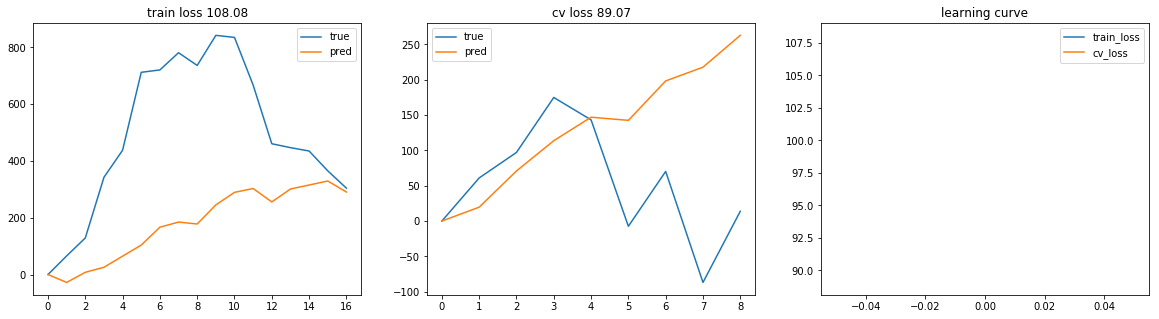

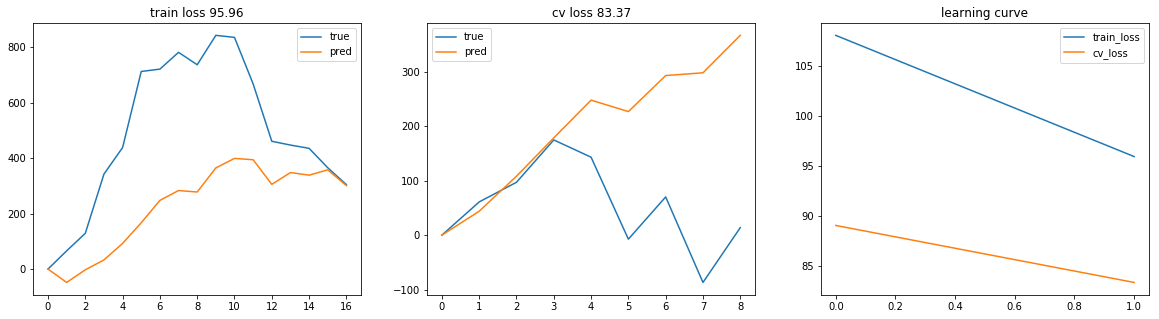

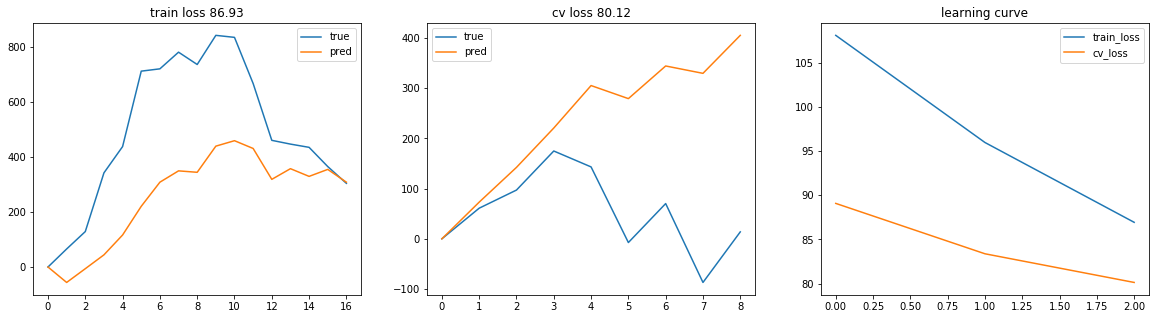

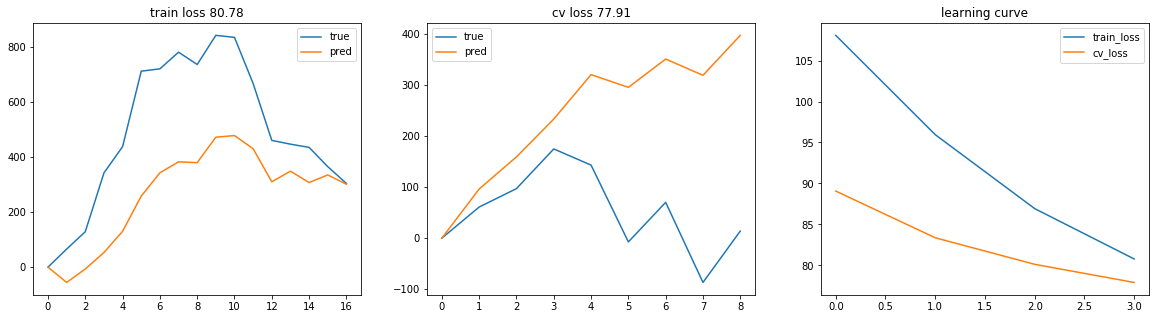

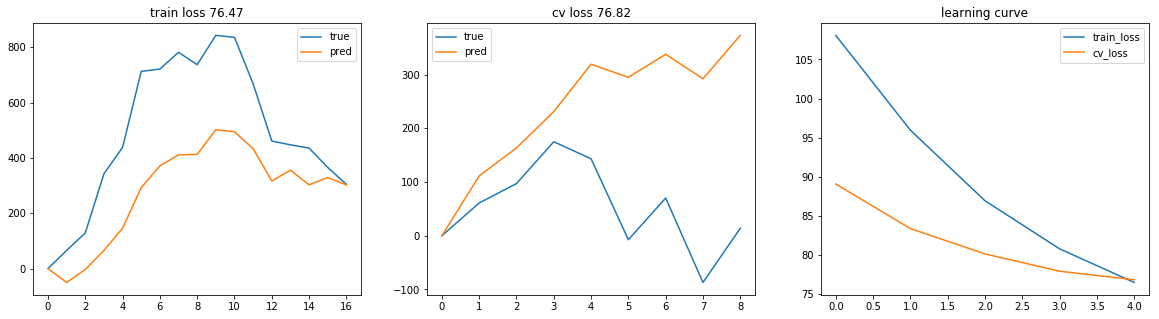

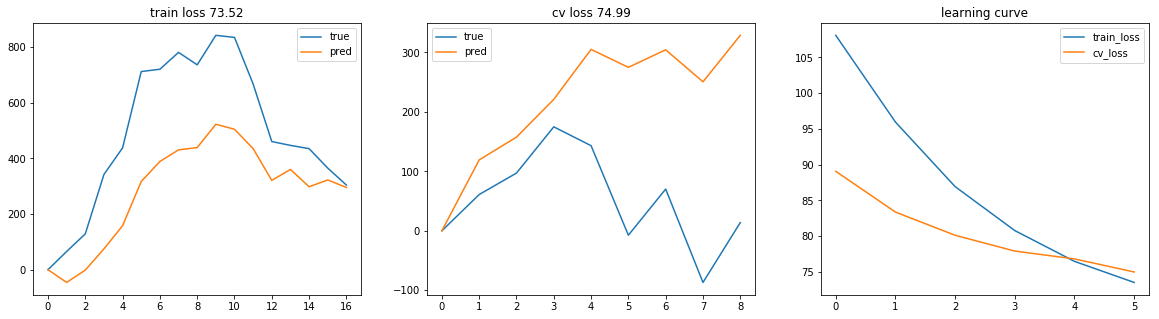

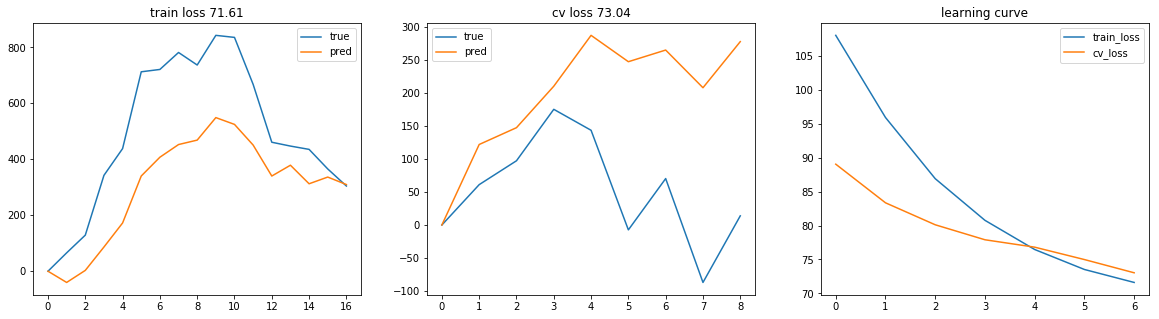

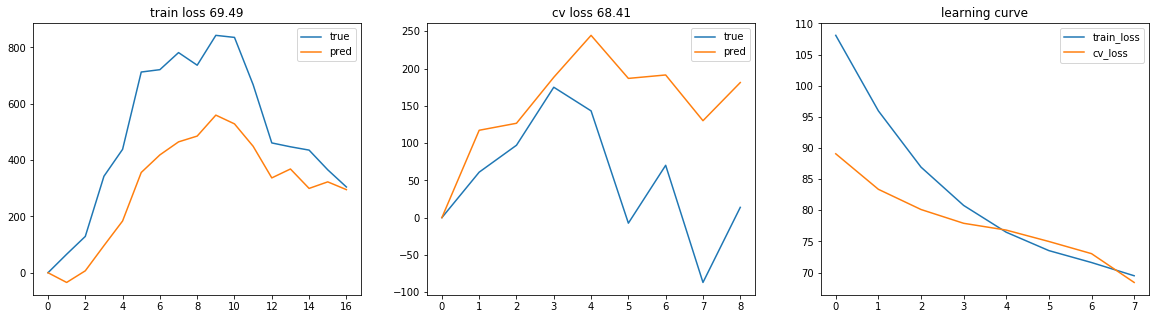

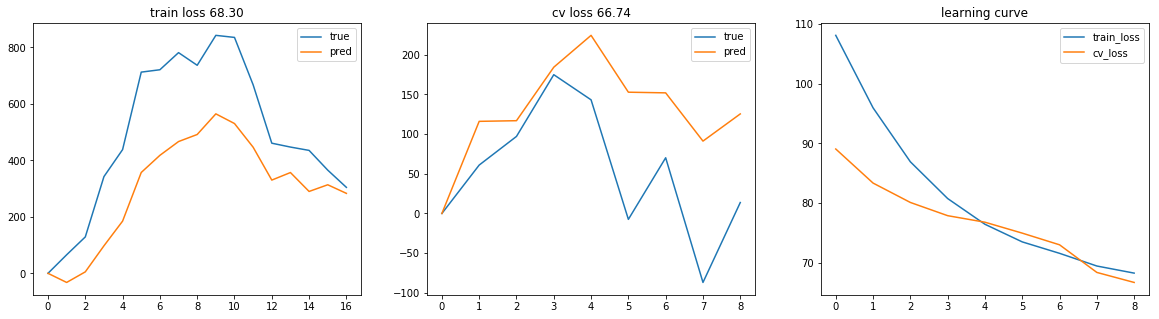

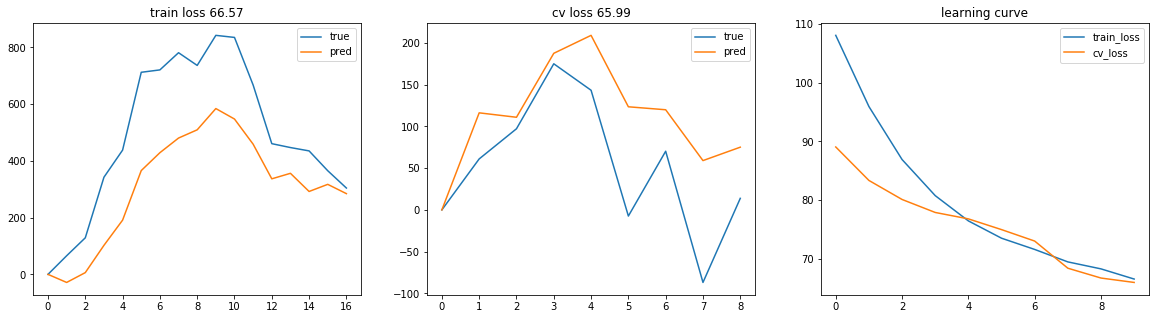

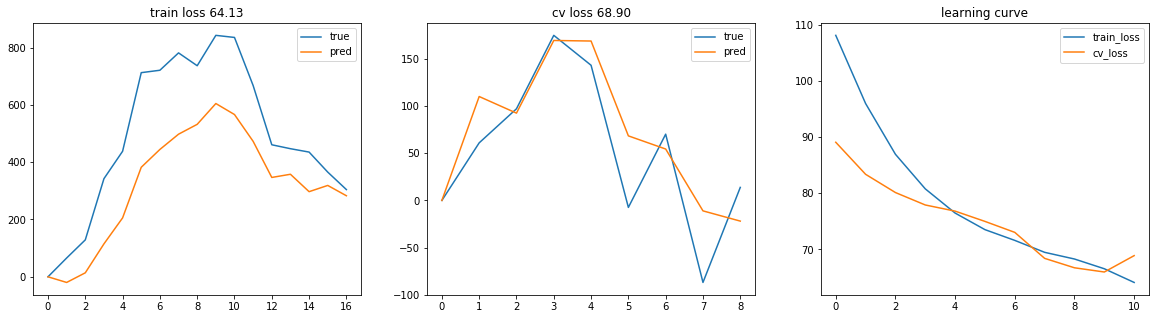

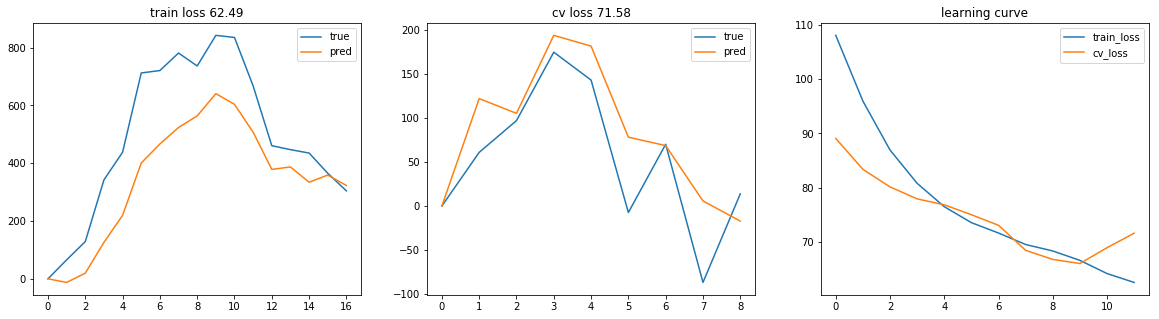

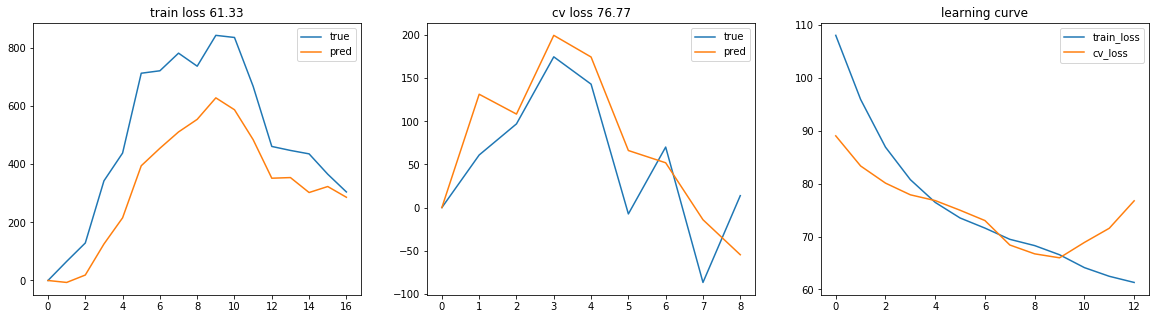

early stopping, best cv loss: 65.98734067002084


In [44]:
for i in range(EPOCHS):
    model.fit(X, y, epochs=1, shuffle=False, verbose=0, batch_size=BATCH_SIEE)
    model.reset_states()
    
    if (i+1) % 500 == 0:
        _, _, train_loss, train_grow_true, train_grow_pred = evaluate(model, train_scaled, title='train set')
        _, _, cv_loss, cv_grow_true, cv_grow_pred = evaluate(model, cv_scaled, title='cv set')
        
        train_loss_his.append(train_loss)
        cv_loss_his.append(cv_loss)
        
        fig, ax = plt.subplots(1, 3, figsize = (20, 5))
        
        ax[0].plot(train_grow_true, label='true')
        ax[0].plot(train_grow_pred, label='pred')
        ax[0].set_title('train loss {:.2f}'.format(train_loss))
        ax[0].legend()
        
        ax[1].plot(cv_grow_true, label='true')
        ax[1].plot(cv_grow_pred, label='pred')
        ax[1].set_title('cv loss {:.2f}'.format(cv_loss))
        ax[1].legend()
        
        ax[2].plot(train_loss_his, label='train_loss')
        ax[2].plot(cv_loss_his, label='cv_loss')
        ax[2].set_title('learning curve')
        ax[2].legend()
        
        plt.show()

        if cv_loss < best_cv_loss:
            best_cv_loss = cv_loss
            patience = 0
        else:
            patience += 1
            if patience >= MAX_PATIENCE:
                print('early stopping, best cv loss: {}'.format(best_cv_loss))
                break